# Week 4 - Evaluation Metrics

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

## Data Preparation

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

df = pd.read_csv(url)

In [3]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/home/v11s3rkr/anaconda3/envs/ml_zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummy Model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

Accuracy measures the fraction of correct predictions. Specifically, it is the number of correct predictions divided by the total number of predictions.

We can change the decision threshold, it should not be always 0.5. But, in this particular problem, the best decision cutoff, associated with the hightest accuracy (80%), was indeed 0.5.

Note that if we build a dummy model in which the decision cutoff is 1, so the algorithm predicts that no clients will churn, the accuracy would be 73%. Thus, we can see that the improvement of the original model with respect to the dummy model is not as high as we would expect.

Therefore, in this problem accuracy can not tell us how good is the model because the dataset is unbalanced, which means that there are more instances from one category than the other. This is also known as class imbalance.

Classes and methods:

- `np.linspace(x,y,z)` - returns a numpy array starting at x until y with z evenly spaced samples
- `Counter(x)` - collection class that counts the number of instances that satisfy the x condition
- `accuracy_score(x, y)` - sklearn.metrics class for calculating the accuracy of a model, given a predicted x dataset and a target y dataset.


In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).mean()

0.8034066713981547

In [10]:
1132 / 1409

0.8034066713981547

In [11]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [12]:
thresholds = np.linspace(0, 1, 21)
scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


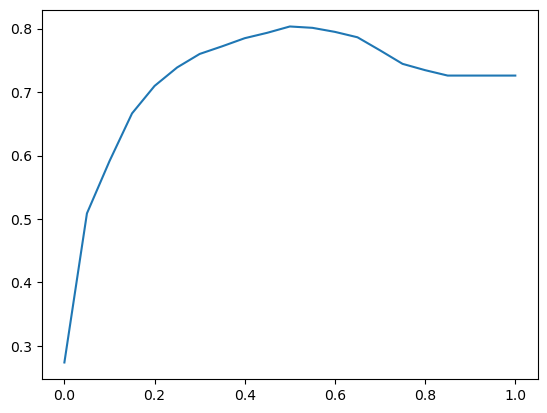

In [13]:
plt.plot(thresholds, scores);

In [14]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [15]:
1 - y_val.mean()

0.7260468417317246

## Confusion Table
- Different types of errors and correct decisions
- Arranging them in a table

Confusion table is a way of measuring different types of errors and correct decisions that binary classifiers can make. Considering this information, it is possible to evaluate the quality of the model by different strategies.

When comes to a prediction of an LR model, each falls into one of four different categories:

- Prediction is that the customer WILL churn. This is known as the Positive class
    - And Customer actually churned - Known as a True Positive (TP)
    - But Customer actually did not churn - Known as a False Positive (FP)
- Prediction is that the customer WILL NOT churn' - This is known as the Negative class
    - Customer did not churn - True Negative (TN)
    - Customer churned - False Negative (FN)

'Confusion Table' is a way to summarize the above results in a tabular format.

The accuracy corresponds to the sum of TN and TP divided by the total of observations.

In [16]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [17]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [18]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [19]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])

confusion_matrix

array([[922, 101],
       [176, 210]])

In [20]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

Precision tell us the fraction of positive predictions that are correct. It takes into account only the positive class (TP and FP - second column of the confusion matrix), as is stated in the following formula:

P = T P / T P + F P

Recall measures the fraction of correctly identified postive instances. It considers parts of the postive and negative classes (TP and FN - second row of confusion table). The formula of this metric is presented below:

R = T P / T P + F N

In this problem, the precision and recall values were 67% and 54% respectively. So, these measures reflect some errors of our model that accuracy did not notice due to the class imbalance.

Exemplo:

Imagine um sistema de detecção de fraude em transações bancárias:

- Alta precisão, baixo recall: O sistema só sinaliza como fraude quando está muito certo, mas pode deixar passar algumas fraudes (falsos negativos).

- Baixa precisão, alto recall: O sistema sinaliza muitas transações como fraude, incluindo muitas que não são (falsos positivos), mas dificilmente deixa escapar uma fraude real.

Assim, a escolha entre dar mais importância à Precision ou ao Recall depende do contexto do problema e das suas consequências práticas.


In [21]:
# when false positives are more important,
# when they are expensive or we want to minimize them
p = tp / (tp+fp)
p

0.6752411575562701

In [22]:
# when is more important to find most true positives
# and false negatives are problematic
r = tp / (tp + fn)
r

0.5440414507772021

In [23]:
tp + fn

386

## Roc Curves

Classes and methods:

- np.repeat([x,y], [z,w]) - returns a numpy array with a z number of x values, and a w number of y values.
- roc_curve(x, y) - sklearn.metrics class for calculating the false positive rates, true positive rates, and thresholds, given a target x dataset and a predicted y dataset.


ROC stands for Receiver Operating Characteristic, and this idea was applied during the Second World War for evaluating the strength of radio detectors. This measure considers False Positive Rate (FPR) and True Positive Rate (TPR), which are derived from the values of the confusion matrix.

FPR is the fraction of false positives (FP) divided by the total number of negatives (FP and TN - the first row of confusion matrix), and we want to `minimize` it.

In the other hand, TPR or Recall is the fraction of true positives (TP) divided by the total number of positives (FN and TP - second row of confusion table), and we want to `maximize` this metric. 

### TPR and FRP

In [24]:
tpr = tp / (tp+fn)
tpr

0.5440414507772021

In [25]:
fpr = fp / (fp + tn)
fpr

0.09872922776148582

In [26]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [27]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

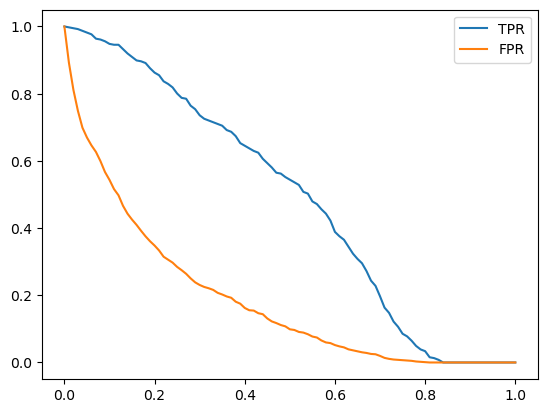

In [28]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random Model

In [29]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [30]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [31]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [32]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

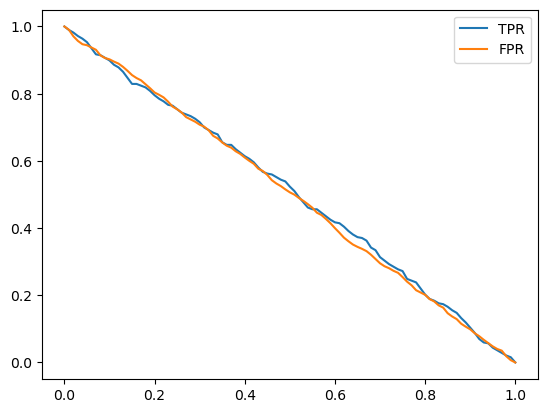

In [33]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [34]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [35]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [36]:
1 - y_val.mean()

0.7260468417317246

In [37]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [38]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


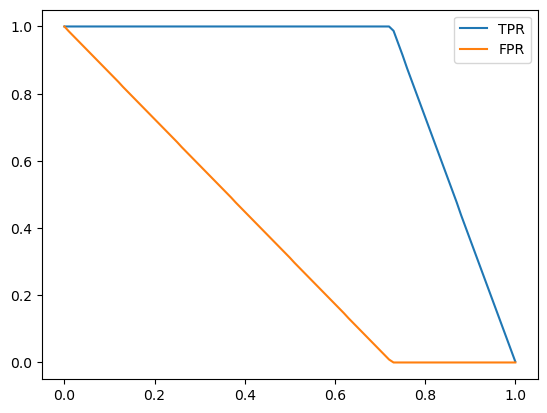

In [39]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

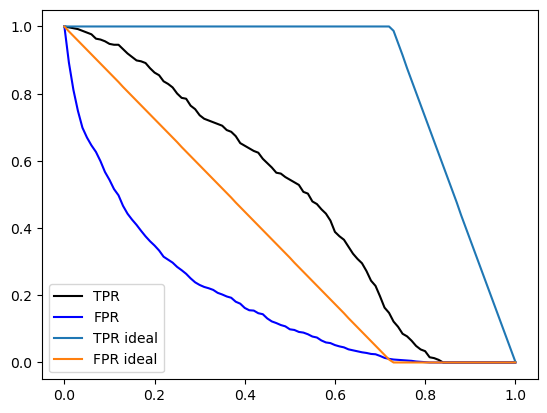

In [40]:


plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

plt.legend()



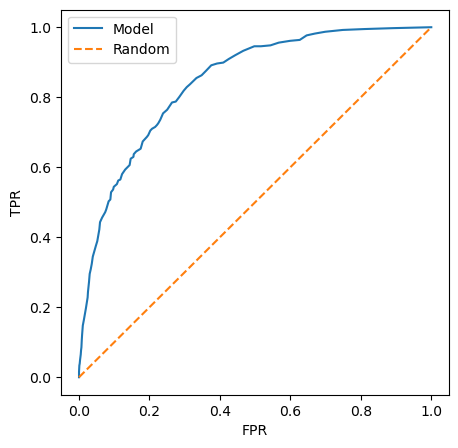

In [41]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### With Scikit-Learn

In [42]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

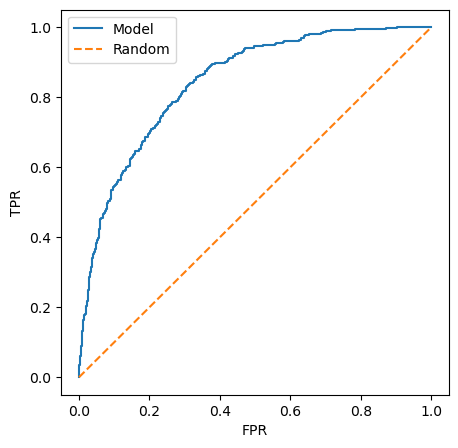

In [43]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

The Area under the ROC curves can tell us how good is our model with a single value. The AUROC of a random model is 0.5, while for an ideal one is 1.

In other words, AUC can be interpreted as the probability that a randomly selected positive example has a greater score than a randomly selected negative example.

Classes and methods:

- `auc(x, y)` - sklearn.metrics class for calculating area under the curve of the x and y datasets. For ROC curves x would be false positive rate, and y true positive rate.
- `roc_auc_score(x, y)` - sklearn.metrics class for calculating area under the ROC curves of the x false positive rate and y true positive rate datasets.
- `randint(x, y, size=z)`- np.random class for generating random integers from the “discrete uniform”; from x (inclusive) to y (exclusive) of size z.

In [44]:
auc(fpr, tpr)

0.8438429084426076

In [45]:
auc(df_scores.fpr, df_scores.tpr)

0.8438593692228993

In [46]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [47]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(fpr, tpr)

0.8438429084426076

In [48]:
roc_auc_score(y_val, y_pred)

0.8438429084426076

In [49]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [50]:
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84454

In [51]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

## Cross-Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [82]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y_train)

    return dv, model

In [83]:
dv, model = train(df_train, y_train, C=0.001)

In [84]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [85]:
y_pred = predict(df_val, dv, model)

In [86]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


In [87]:
scores

[0.843882220879026,
 0.8451012283141306,
 0.8333814970901063,
 0.8347928790688751,
 0.8517814000188259]

In [88]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584357091011516